In [7]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

In [2]:
import ReactiveMP.messageout

In [3]:
data_seed, params_seed = 42, 420

(42, 420)

In [4]:
include("../helpers/data.jl")

generate_data

In [5]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end


In [6]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [566]:
order_y, order_u, order_h =2, 2, 2
order_yu = order_y + order_u
# full_order = order_h + order_y + order_u
# Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
# U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(order_h, order_h+1); H[end-order_h+1:end, end-order_h+1:end] = diageye(order_h);
H

2×3 Matrix{Float64}:
 0.0  1.0  0.0
 0.0  0.0  1.0

In [567]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [568]:
function polynomial(x)
    return x
end

polynomial (generic function with 1 method)

In [656]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, h_prior, w1_prior, η_prior, w2_prior, y_prev, u, h_order)
    
    obs_prec = 1e6;
    
    # initialize variables
    θ1      = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order+1), 1e12*diageye(h_order+1)))}
    w       = randomvar()
    h       = randomvar(n)
    θh      = randomvar(n)
    θh1     = randomvar(n)
    Φ       = randomvar(n)
    yuh1    = randomvar(n)
    yuh2    = randomvar(n)
    aux     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    YUs = [polynomial([y_prev[i]; u[i]]) for i in 1:length(y_prev)]
#     order_yu = length(YUs[1])
    
    AR_meta_1 = ARMeta(Multivariate, h_order+1, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, h_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w1   ~ GammaShapeRate(w1_prior[1], w1_prior[2])
    θ1   ~ MvNormalMeanPrecision(zeros(h_order+1), diageye(h_order+1))
    θ2 ~ MvNormalMeanPrecision(randn(h_order), diageye(h_order))
    w2 ~ GammaShapeRate(w2_prior[1], w2_prior[2])
    
    η  ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    
    c = zeros(h_order+1); c[1] = 1.0;
    b = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t]  ~ AR(h_prev, θ1, w1) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_1}
        
        θh[t] ~ AR(H*h[t], θ2, w2) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
        
        θh1[t]  ~ dot(θh[t], b)
        
        yuh1[t] ~ (θh1[t] + dot(h[t], c)) where {q = FullFactorisation()}
        
        Φ[t] ~ dot(η, YUs[t])
        
        yuh2[t] ~ (yuh1[t] + Φ[t]) where {q = FullFactorisation()}
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(yuh2[t], obs_prec)
        
        h_prev = h[t]
    end

    return θ1, w1, θ2, w2, h, η, y_nodes, y
end

nonlinear_max_mv (generic function with 1 method)

In [657]:
function nonlinear_max_inference_mv(observations, observations_prev, controls;
                                    h_order,
                                    h_prior=(randn(h_order), diageye(h_order)),
                                    w1_prior=(1.0, 1.0), 
                                    η_prior=(zeros(2), diageye(2)),
                                    w2_prior=(1.0, 1.0), vmp_its=10)
    
    
    n = length(observations)

    # define model
    model, (θ1, w1, θ2, w2, h, η, y_nodes, y) = nonlinear_max_mv(n, h_prior, w1_prior, η_prior, w2_prior, 
                                                                 observations_prev, controls, h_order,
                                                                 options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ1_buffer = nothing
    θ2_buffer = nothing
    w1_buffer = nothing
    w2_buffer = nothing
    η_buffer  = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    
    subscribe!(getmarginal(θ1), (x) -> θ1_buffer = x)
    subscribe!(getmarginal(θ2), (x) -> θ2_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w1), (x) -> w1_buffer = x)
    subscribe!(getmarginal(w2), (x) -> w2_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                             (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(h_order+1), diageye(h_order+1)))
    setmessages!(h, MvNormalMeanPrecision(zeros(h_order+1), diageye(h_order+1)))
    
    setmarginal!(w1, GammaShapeRate(w1_prior[1], w1_prior[2]))
    setmarginal!(θ1, MvNormalMeanPrecision(zeros(h_order+1), diageye(h_order+1)))
    setmarginal!(θ2, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    setmarginal!(w2, GammaShapeRate(w2_prior[1], w2_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ1_buffer, w1_buffer, θ2_buffer, w2_buffer, η_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [658]:
# Read data from CSV file
df = DataFrame(CSV.File("../data/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# Select input and output signals
input = df[:,:V1]
output = df[:,:V2]

# Time horizon
T = length(input);

In [659]:
# normalization
input = (input .- mean(input))/std(input)
output = (output .- mean(output))/std(output)

131072-element Vector{Float64}:
  0.16079923510341107
  0.22775112557812904
  0.18754101784311708
  0.06100846540391118
 -0.08957707645721216
 -0.18838039383721755
 -0.19097550097668597
 -0.10483293373486675
  0.02295126604669645
  0.13305126280854654
  0.17798502765446092
  0.1377374454481209
  0.032407948886333235
  ⋮
 -0.32807023315970646
 -0.3752131180904102
 -0.2764304116696352
 -0.08649480119047896
  0.12356085294471451
  0.28107729827796324
  0.31041980932783675
  0.217070901249631
  0.08335261893326895
 -0.03750817227043455
 -0.1286873084587455
 -0.1506604647219554

In [660]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

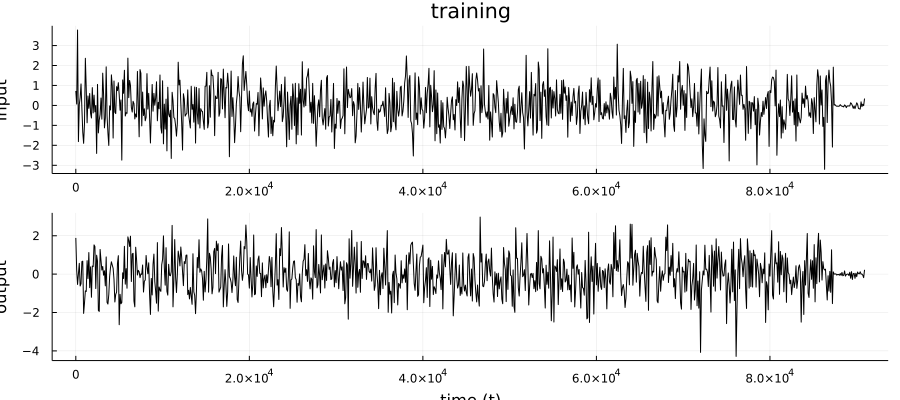

In [661]:
# Plot every n-th time-point to avoid figure size exploding
n = 100
ix = 1:n:T_trn

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

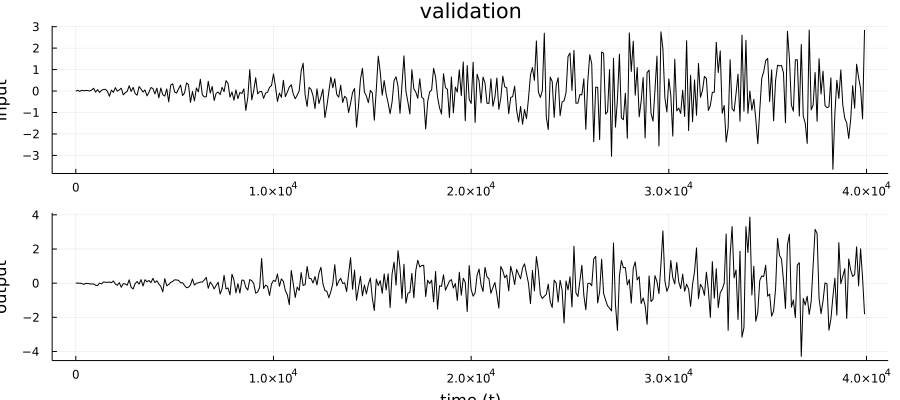

In [662]:
n = 100
ix = 1:n:T_val

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

In [796]:
train_size = 800
test_size = 1000

# Generate training data
observations_prev, observations = ssm(output_trn, order_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, order_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [797]:
@rule AR(:x, Marginalisation) (m_y::NormalDistributionsFamily, q_θ::NormalDistributionsFamily, q_γ::GammaShapeRate, meta::ARMeta) = begin
    mθ, Vθ = mean_cov(q_θ)
    my, Vy = mean_cov(m_y)

    mγ = mean(q_γ)

    mA = ReactiveMP.as_companion_matrix(mθ)
    mV = ReactiveMP.ar_transition(ReactiveMP.getvform(meta), ReactiveMP.getorder(meta), mγ)

    C = mA' * inv(ReactiveMP.add_transition(Vy, mV))
    
    W = C * mA + mγ * Vθ
    ξ = C * my

    return convert(ReactiveMP.promote_variate_type(ReactiveMP.getvform(meta), NormalWeightedMeanPrecision), ξ, W)
end

In [798]:
order_yu = order_y + order_u
# coefs_precision = diageye(full_order)
# coefs_mean = ones(full_order); coefs_mean[end-order_h+1:end] = zeros(order_h)
# coefs_precision[end-order_h+1:end,end-order_h+1:end] = 1e6*diageye(order_h)

fe_, h_, θ1_, w1_, θ2_, w2_, η_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, h_order=order_h, h_prior=(randn(order_h+1), diageye(order_h+1)), w1_prior=(1e-4, 1.0), η_prior=(zeros(order_yu), diageye(order_yu)), w2_prior=(1e4, 1.0), vmp_its=10);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


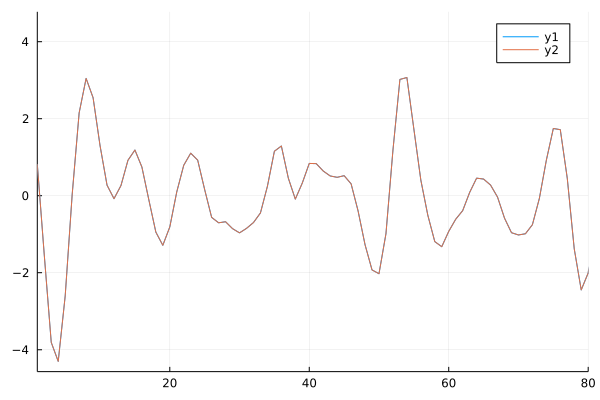

In [800]:
mfrom, mto = 1, 80
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

In [801]:
mean(w1_)

264.9599244706212

In [802]:
mean(w2_)

9998.995106359895

In [803]:
mean(θ1_)

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [804]:
mean(θ2_)

2-element Vector{Float64}:
 -0.0014483806184512813
  0.002611308272386309

In [805]:
mean(η_)

4-element Vector{Float64}:
  1.4458493906640508
 -0.9342302104379523
  0.16525593815853026
  0.007743623357931319

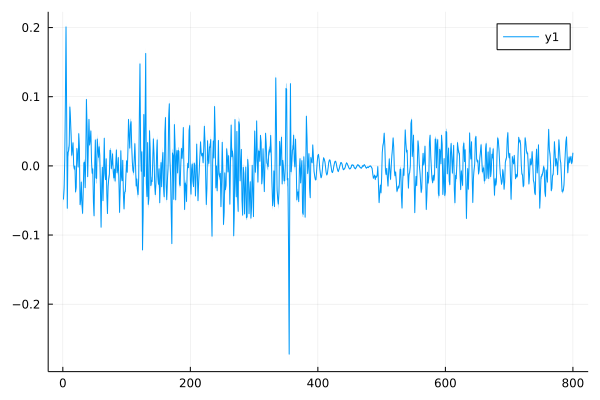

In [806]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## KF-like prediction

In [807]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [815]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(w1, h_prior, η_prior, θ2_prior, w2_prior, y_prev, u, h_order)

    A = shift(h_order) # transition matrix
    V = transition(w1, h_order)

    # initialize variables
    y_pred   = datavar(Float64)
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h  ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    η  ~ MvNormalMeanCovariance(η_prior[1], η_prior[2])
    yu = polynomial([y_prev; u])
    
    AR_meta_2 = ARMeta(Multivariate, h_order-1, ARsafe())
    θ2 ~ MvNormalMeanPrecision(θ2_prior[1], θ2_prior[2])
    w2 ~ GammaShapeRate(w2_prior[1], w2_prior[2])
    θh ~ AR(H*h, θ2, w2) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
    
    c = zeros(h_order); c[1] = 1.0
    b = zeros(h_order-1); b[1] = 1.0
    aux ~ dot(h, c) + dot(θh, b)
    y_node, y ~ (dot(yu, η) + aux)
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, θ2, θh, w2, η, y_node, y, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 2 methods)

In [816]:
function nonlinear_max_prediction_mv(observation_prev, control, w1, h_prior, η_prior, θ2_prior, w2_prior; vmp_its = 50)

    # define model
    h_order = length(h_prior[1])
    model, (h, h_0, θ2, θh, w2, η, y_node, y, y_pred) = nonlinear_max_prediction_mv_model(w1, h_prior, η_prior, θ2_prior, w2_prior, observation_prev, control, h_order,
                                                                                      options = (limit_stack_depth = 500, ))
        
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    setmessage!(θ2, MvNormalMeanPrecision(θ2_prior[1], θ2_prior[2]))
    setmessage!(w2, GammaShapeRate(w2_prior[1], w2_prior[2]))
    setmessage!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
    setmessage!(θh, MvNormalMeanPrecision(zeros(h_order-1), diageye(h_order-1)))
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 3 methods)

In [817]:
fe_buffer, h_buffer, h0_buffer, y_pred_buffer = fe_buffer, h_buffer, h0_buffer, y_pred_buffer = nonlinear_max_prediction_mv(X_test[2], U_test[2], w1_prior, h_prev, η_prior, θ2_prior, w2_prior, vmp_its=1)

(Any[], nothing, Marginal(MvNormalMeanPrecision(
μ: [0.018931288260873407, 0.006764422163820271, 0.0034708355698038094]
Λ: [148409.31627895666 0.0 0.0; 0.0 169759.88525809493 -0.15062667127415913; 0.0 -0.15062667127415913 179257.48058386674]
)
), Marginal(NormalWeightedMeanPrecision{Float64}(xi=2.591792643033119e-5, w=0.0011861222871665813)))

In [818]:
mean(y_pred_buffer)

0.021850973302461208

In [823]:
predictions = []


h_prev = (mean(h_[end]), precision(h_[end]))
η_prior = mean_precision(η_)
θ2_prior = mean_precision(θ2_)
w2_prior = (shape(w2_), rate(w2_))
w1_prior = mean(w1_)

batch = 1
for i in batch:length(X_test)
    fe_pred, h_pred, h0_pred, y_pred = nonlinear_max_prediction_mv(X_test[i], U_test[i], w1_prior, h_prev, η_prior, θ2_prior, w2_prior, vmp_its=10)
    push!(predictions, y_pred)
    
#     _, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], y_order=order_y, u_order=order_u, w_prior=(shape(w_), rate(w_)), 
#                                                             η_prior=(mean(η_), diageye(full_order)), τ_prior=(shape(τ_), rate(τ_)), h_order=order_h, vmp_its=100);
    
#     _, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv(Y_test[i-batch+1:i], X_test[i-batch+1:i], U_test[i-batch+1:i], y_order=order_y, u_order=order_u, w_prior=(shape(w_), rate(w_)), 
#                                                             η_prior=(mean(η_), precision(η_)), τ_prior=(shape(τ_), rate(τ_)), h_order=order_h, vmp_its=10);
    
    h_prev = (mean(h_[end]), precision(h_[end]))
    η_prior = mean_precision(η_)
    θ2_prior = mean_precision(θ2_)
    w2_prior = (shape(w2_), rate(w2_))
    w1_prior = mean(w1_)
    
end

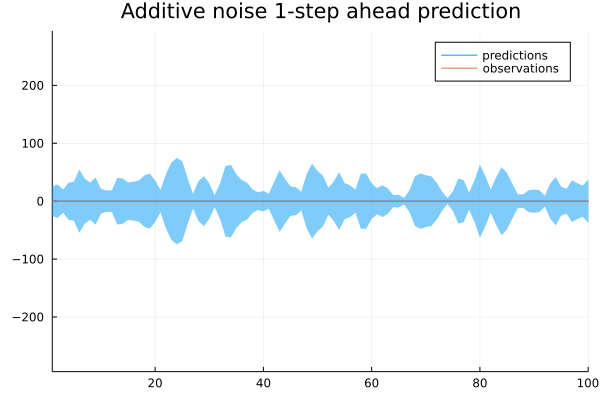

In [824]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 100), title="Additive noise 1-step ahead prediction", label="observations")

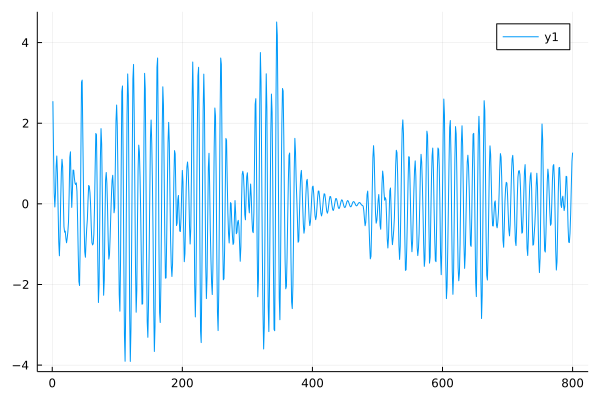

In [467]:
plot(Y_train)